# Create a logistic regression model to predict RIT1 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'RIT1' classifier 
GENE = '6016'# RIT1

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/RIT1) about RIT1*

## Load Data

In [4]:
%%time
path = os.path.join('..', 'download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 13s, sys: 636 ms, total: 1min 14s
Wall time: 1min 14s


In [5]:
%%time
path = os.path.join('..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 43.3 s, sys: 284 ms, total: 43.6 s
Wall time: 43.5 s


In [6]:
y = Y[GENE]

In [7]:
# The Series now holds RIT1 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    0
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
TCGA-04-1348-01    0
Name: 6016, dtype: int64

In [8]:
# Here are the percentage of tumors with RIT1
y.value_counts(True)

0    0.997126
1    0.002874
Name: 6016, dtype: float64

## Set aside 10% of the data for testing

In [9]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,530 features, 6,575 training samples, 731 testing samples'

## Feature Standardization

In [10]:
%%time
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

CPU times: user 1.9 s, sys: 1.75 s, total: 3.65 s
Wall time: 6.16 s


## Reducing noise via PCA

In [11]:
%%time
n_components = 50
pca = PCA(n_components=n_components, random_state=0)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

CPU times: user 14.9 s, sys: 1.23 s, total: 16.2 s
Wall time: 6.89 s


## Dimensionality reduction via LDA

In [12]:
%%time

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 63.1 ms


## Parameters

In [13]:
param_grid = {
    'alpha': [10 ** x for x in range(-4, 1)],
    'l1_ratio': [0, 0.2, 0.5, 0.8, 1],
}

In [14]:
%%time
clf = SGDClassifier(random_state=0, class_weight='balanced', loss='log', penalty='elasticnet')
cv = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
cv.fit(X = X_train_lda, y=y_train)

CPU times: user 1.02 s, sys: 268 ms, total: 1.29 s
Wall time: 2.42 s


In [15]:
# Best Params
print('{:.3%}'.format(cv.best_score_))

# Best Params
cv.best_params_

90.637%


{'alpha': 0.0001, 'l1_ratio': 0}

## Visualize hyperparameters performance

In [16]:
cv_result_df = pd.concat([
    pd.DataFrame(cv.cv_results_),
    pd.DataFrame.from_records(cv.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,alpha,l1_ratio
0,0.009799,0.002078,0.906367,0.908201,0.0001,0,"{'l1_ratio': 0, 'alpha': 0.0001}",1,0.911177,0.906533,0.924291,0.899193,0.883623,0.918878,0.000345,0.000182,0.016947,0.008122,0.0001,0.0
1,0.006377,0.002129,0.906367,0.908201,0.0001,0.2,"{'l1_ratio': 0.2, 'alpha': 0.0001}",1,0.911177,0.906533,0.924291,0.899193,0.883623,0.918878,0.000085,0.000812,0.016947,0.008122,0.0001,0.2


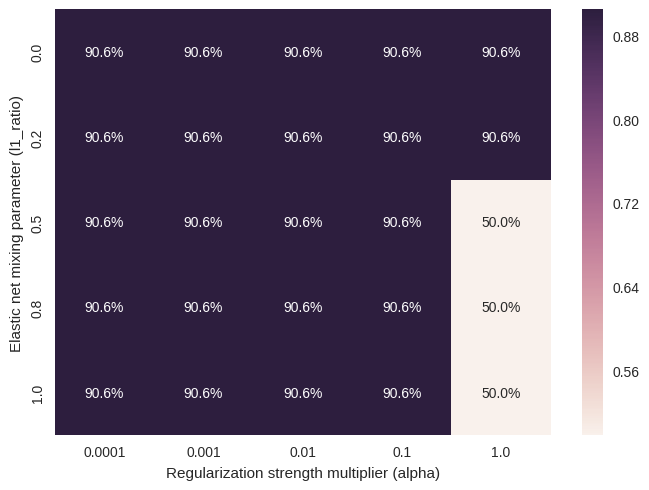

In [17]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [18]:
y_pred_train = cv.decision_function(X_train_lda)
y_pred_test = cv.decision_function(X_test_lda)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

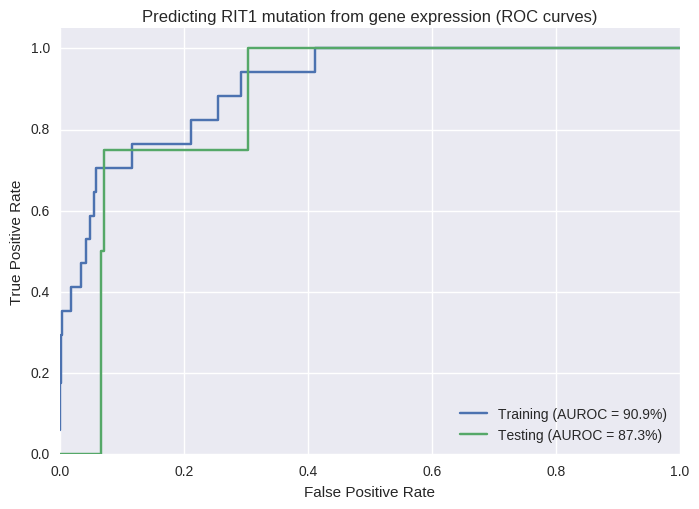

In [19]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting RIT1 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Investigate the predictions

In [20]:
X_transformed = lda.transform(pca.transform(X))

In [21]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', cv.decision_function(X_transformed)),
    ('probability', cv.predict_proba(X_transformed)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [22]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-C5-A2LS-01,TCGA-C5-A2LS-01,0,0,-30.017746,9.193025e-14,0.0%
TCGA-C5-A2M2-01,TCGA-C5-A2M2-01,0,0,-44.053545,7.375447e-20,0.0%
TCGA-78-7540-01,TCGA-78-7540-01,0,0,-47.364081,2.691790e-21,0.0%
TCGA-EK-A2RL-01,TCGA-EK-A2RL-01,0,0,-49.892208,2.148272e-22,0.0%
TCGA-IR-A3LI-01,TCGA-IR-A3LI-01,0,0,-50.518993,1.147836e-22,0.0%
TCGA-44-6146-01,TCGA-44-6146-01,0,0,-53.305856,7.072304e-24,0.0%
TCGA-71-6725-01,TCGA-71-6725-01,0,0,-56.839117,2.065785e-25,0.0%
TCGA-78-7147-01,TCGA-78-7147-01,0,0,-64.249567,1.249590e-28,0.0%
TCGA-55-A492-01,TCGA-55-A492-01,0,0,-64.650190,8.371037e-29,0.0%


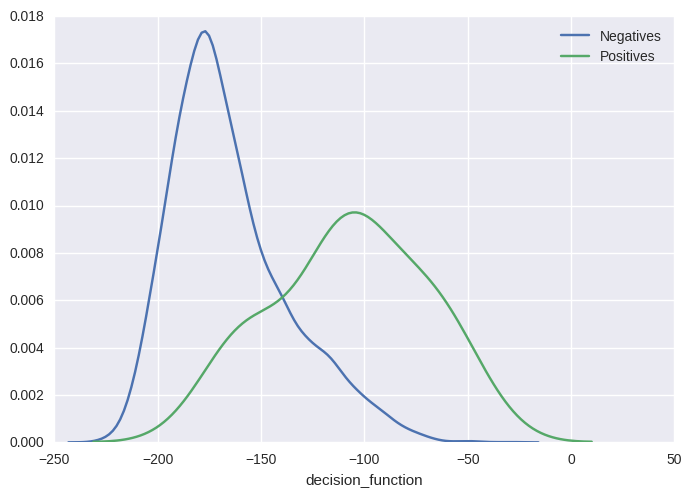

In [23]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

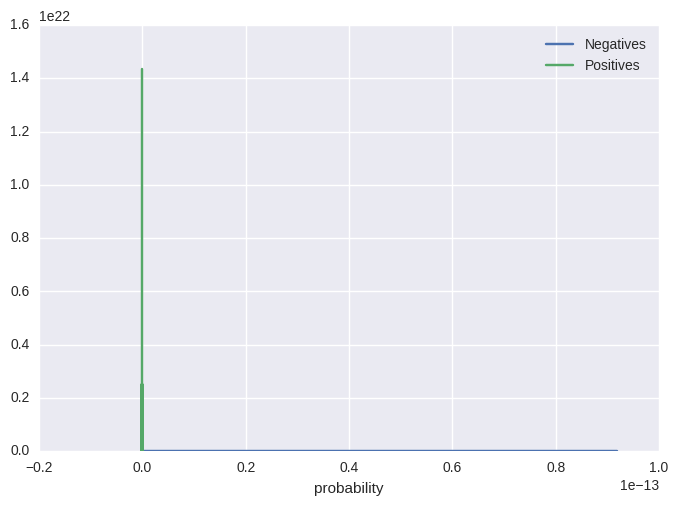

In [24]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')